In [1]:
import sys, os, glob, datetime, cftime
import xarray as xr
import numpy as np
import pandas as pd
from scipy import float64
from dill.source import getsource

sys.path.append('../')

from _decomp import *
from _data_minimal import *
from _print_and_plot import *

%load_ext autoreload 
%autoreload 2

In [2]:
target_variable='TREFHT'
cov_variable = 'Z500'
months=[6,7,8]
period = [1850,2099]

In [3]:
runs = []
for run in [1300,1400,1500]:
    runs += [Struct(**dict(exp='CC', obj=decomp_CESM2_cc, run=run, color='darkorange'))]
    runs += [Struct(**dict(exp='piN', obj=decomp_CESM2_piN, run=run, color='darkcyan'))]
#runs += [Struct(**dict(exp='cc322', obj=decomp_CESM2_cc322, run=1300, color='m'))]
#runs += [Struct(**dict(exp='cc691', obj=decomp_CESM2_cc691, run=1300, color='r'))]
for run in runs:
    run.name = f"{run.exp} {run.run}"
for run in runs:
    run.lsty = {1300:'-', 1400:':', 1500:'-.'}[run.run]
runs = {run.name: run for run in runs}

In [4]:
for run_name,run in runs.items():
    run.obj = run.obj(run=run.run, target_variable=target_variable, months=months, period=period)
    run._x = {}

# One location

In [5]:
lon = 12.2
lat = 51.2

In [6]:
for var in ['Z500','TOTPREC','PSL','TREFHT']:
    for run in runs.values():
        fl = run.obj.get_raw_file_names(var=var, time_freq='day')
        run._x[var] = xr.open_mfdataset(fl)[var].sel(dict(lon=lon, lat=lat), method='nearest')

In [7]:
for run in runs.values():
    run._x['TOTPREC'] *= 3600 * 24

In [8]:
for run in runs.values():
    run._x['TREFHT'] -= 273.15

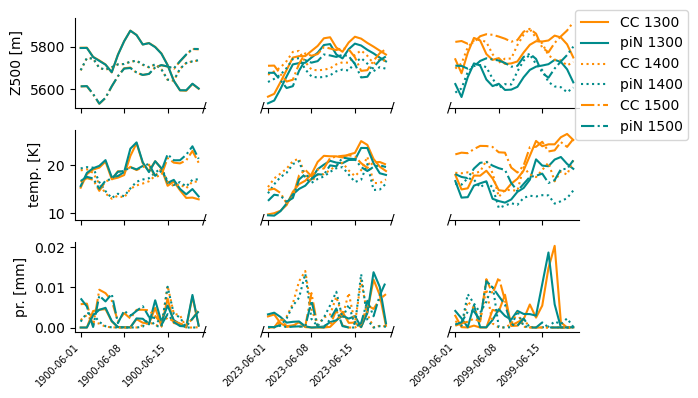

In [9]:
run = 1300
fig,axes = plt.subplots(nrows=3, ncols=4, figsize=(7,4), sharex='col', sharey='row', width_ratios=[3,3,3,1])
for ax in axes[:,-1]:
    ax.axis('off')
for r, var, ylab in zip(
    [0,1,2],
    ['Z500','TREFHT','TOTPREC'],
    ['Z500 [m]', 'temp. [K]', 'pr. [mm]']
    ):
    axes[r,0].set_ylabel(ylab)
    for c,year in enumerate([1900,2023,2099]):
        ax = axes[r,c]
        if c > 0:
            ax.tick_params(axis='y', which='both', left=False)
            ax.spines[['left', 'right', 'top']].set_visible(False)
        else:
            ax.spines[['right', 'top']].set_visible(False)
        ax.set_xticks(range(0,21,7))
        ax.set_xticklabels([f"{year}-06-{str(i+1).zfill(2)}" for i in range(0,21,7)], rotation=45, fontsize=7, ha='right')
        if c < 2:
            ax.annotate(r'/', xy=(1,0), xycoords="axes fraction", fontsize=10, zorder=101, horizontalalignment='center', verticalalignment='center')
        if c > 0:
            ax.annotate(r'/', xy=(0,0), xycoords="axes fraction", fontsize=10, zorder=101, horizontalalignment='center', verticalalignment='center')

        for run_number in [1300,1400,1500]:
            for run in [runs[f"CC {run_number}"], runs[f"piN {run_number}"]]:
                ax.plot(run._x[var].loc[f"{year}-06"][:20], color=run.color, linestyle=run.lsty, label=run.name)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1,1))
plt.tight_layout()
savefig(f"differences_at_location.pdf")

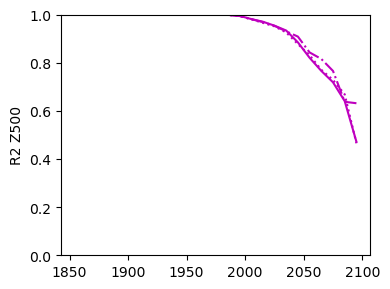

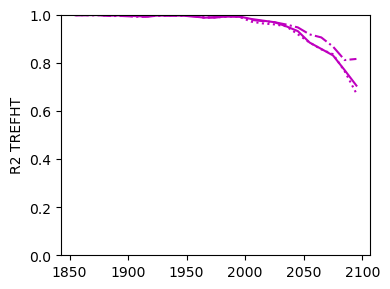

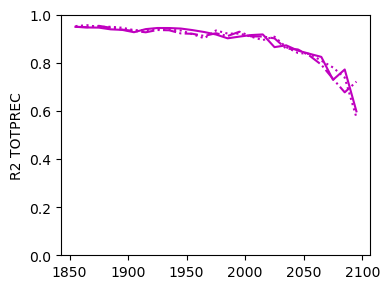

In [11]:
for r, var in enumerate(['Z500','TREFHT','TOTPREC']):
    fig,ax = plt.subplots(figsize=(4,3))
    for run_number in [1300,1400,1500]:
        r2 = []
        years = np.arange(1855,2105,10)
        for year in years:
            cc = runs[f"CC {run_number}"]._x[var].loc[str(year-5):str(year+5)]
            piN = runs[f"piN {run_number}"]._x[var].loc[str(year-5):str(year+5)]
            r2.append(float(1 - np.sum((cc - piN)**2) / np.sum((cc - cc.mean())**2)))
        ax.plot(years, r2, color='m', linestyle=runs[f"CC {run_number}"].lsty)
    ax.set_ylabel(f"R2 {var}")
    ax.set_ylim(0,1)
    plt.tight_layout()
    savefig(f"R2_at_location_{var}.pdf")